In [1]:
import sys

sys.path.append("../..")
from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling import plotting as cgp
import numpy as np

# Model Declaration 

A CGE model is comprised of three components:

1. Variables: symbolic objects that represent model quantities that will vary endogenously in your model.
2. Parameters: symbolic objects that represent model quantities that will vary exogenously in your model (or not at all!)
3. Equations: A mathematical description of your model economy.

To create a model, one first must write down all the variables and parameters that will go into the model.

## Model Setup

In this first simple model, we consider an economy with a single household and a single firm. The household has fixed endowments of labor and capital, which it sells to the firm for wages and rents, respectively. The firm uses these to produce a single consumption good, which it then sells back to the household. There is no government and no investment. The structure of the economy is shown in the following graph:

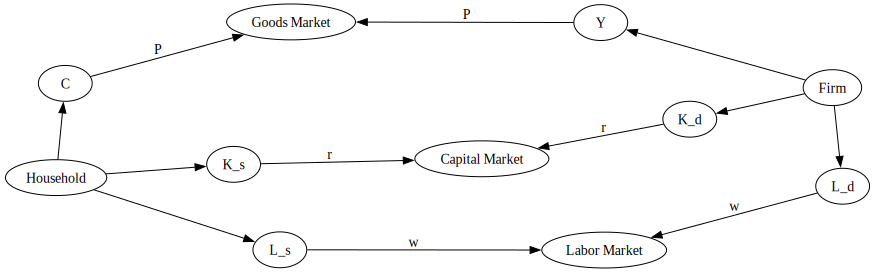

In [2]:
import graphviz as gr


def draw_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(
        graph_attr={"rankdir": graph_direction, "ratio": "0.25"},
        engine="neato",
    )

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


nodes = ["K", "L", "Y", "C", "Household", "Firm"]
edges = [
    ("Household", "K_s"),
    ("Household", "L_s"),
    ("Household", "C"),
    ("Firm", "Y"),
    ("Firm", "K_d"),
    ("Firm", "L_d"),
    ("K_d", "Capital Market"),
    ("L_d", "Labor Market"),
    ("K_s", "Capital Market"),
    ("L_s", "Labor Market"),
    ("C", "Goods Market"),
    ("Y", "Goods Market"),
]
edge_props = {
    ("K_d", "Capital Market"): {"label": "r"},
    ("K_s", "Capital Market"): {"label": "r"},
    ("L_d", "Labor Market"): {"label": "w"},
    ("L_s", "Labor Market"): {"label": "w"},
    ("C", "Goods Market"): {"label": "P"},
    ("Y", "Goods Market"): {"label": "P"},
}
draw_graph(edges, edge_props=edge_props, graph_direction="LR")

Given this structure, the economy will be comprised of the following equations:

$$
\begin{align}
    Y &= C & \text{Goods market clearing} \\
    K_d &= K_s & \text{Capital market clearing} \\
    L_d &= L_s & \text{Labor market clearing} \\
    Y &= f(K_d, L_d) & \text{Production function} \\
    \frac{r}{P} &= \frac{\partial f \left (K_d, L_d \right )}{\partial K_d} & \text{Firm demand for capital} \\
    \frac{w}{P} &= \frac{\partial f \left (K_d, L_d \right )}{\partial L_d} & \text{Firm demand for labor} \\
    PC &= rK_s + wL_s + \Pi & \text{Household budget constraint}
\end{align}
$$

Since we are an endowment economy, we take $K_s$ and $L_s$ as given -- they are thus parameters. The variables are $Y$, $C$, $K_d$, $L_d$, $w$, $r$, and $P$. $\Pi$, the profits of the firm, we set to zero to eliminate. So we have 7 variables and 7 unknowns.

### Underdetermination

The system above looks square, but actually it's not! The household budget constraint is equivalent to the goods market clearning condition. To see this, you have to know that the equations for the firm's factor demand are based on the zero profit condtion. Suppose we don't eliminate $\Pi$, and instead use the identity:

$$\Pi = P Y - r K_d - w L_d$$

Substituting this into the household budget constraint, we obtain:

$$PC = r K_s + w L_s + P Y - r K_d - w L_d $$

From the factor clearing conditions we have $K_d = K_s$ and $L_d = L_s$, so we can make these substitutions:

$$\begin{align}
PC &= r K_s - r K_s + w L_s - w L_s + PY \\
PC &= PY \\
C &= Y
\end{align}
$$

We recovered the market clearing condition from the other equations! This shows that although we wrote down 7 equations, we actually only have 6 equations worth of information.

### Walras' Law and Choice of Numeraire

It's surprising that we only have 6 independent equations, given that we have 7 variables. But actually we only have 6 variables. This is because of Walras' law. The law says that, given perfect competiton and flexible prices in all markets (which we've assumed), the sum of the values of excess demands (or supplies) must be zero. This is an additional constraint on the economy, which has the effect of pinning down the price of the last good, assuming we know the prices of all other goods. In our case, if we know values of $r$ and $w$, we are *not* free to choose a value for $P$. 

As a result, one of our prices is not actually a variable at all. We are required to choose a numeraire -- a price that all other prices are measured by. The choice of numeraire is the modeler's. I will choose $w$, the wage level, to be the numeraire. As a result, all prices will be expressed in hourly wages.

Conceptually, we think of $w$ as a parameter now (which we will fix to be 1 -- since any numeraire value implies a valid price vector, we might as well choose the easiest possible value). Now we have 6 variables are 7 equations, 6 of which are independent. 

### Squaring up the system

Now we just need to make the system square. We have two choices. First, we could remove one of the redundant equations (either the household budget constraint or the goods market clearing conditions). Alternatively, we can add a dummy "residual" variable, which we set to zero. This second choice is popular because it adds a consistency check to model simulations. This residual should always be zero, at all valid equlibria. 

We will add a residual term, $\varepsilon$, to the market clearing condition. So our system now becomes:

### The Final System

Finally, we need to specify a production function. We can use Cobb-Douglas, so $Y = f(K_d, L_d) = AK_d^\alpha L_d^{1-\alpha}$.

The system then becomes:

$$
\begin{align}
    Y &= C + \varepsilon & \text{Goods market clearing} \\
    K_d &= K_s & \text{Capital market clearing} \\
    L_d &= L_s & \text{Labor market clearing} \\
    Y &= AK_d^\alpha L_d^{1-\alpha} & \text{Production function} \\
    K_d &= \alpha Y \frac{P}{r} & \text{Firm demand for capital} \\
    L_d &= (1 - \alpha) Y \frac{P}{w} & \text{Firm demand for labor} \\
    PC &= rK_s + wL_s + \Pi & \text{Household budget constraint}
\end{align}
$$

Where $Y$, $C$, $K_d$, $L_d$, $r$, $P$, and $\varepsilon$ are variables. $A$, $\alpha$, $L_s$, $K_s$, and $w$ are parameters.

We have 7 variables and 7 independent equations (since the market clearing and budget constraint now vary by $\varepsilon$!), and we are ready to proceed. 

## Declare Variables

First, we make a list of variables using the `Variable` class. In their simplest form, variables have a `name` and a `description`. We can optionally also specify a `latex_name` for pretty printing.

In [3]:
variables = [
    Variable("Y", description="Total output"),
    Variable("C", description="Household constumption"),
    Variable("K_d", description="Firm demand for capital"),
    Variable("L_d", description="Firm demand for labor"),
    Variable("r", description="Rental rate of capital"),
    Variable("P", description="Price of consumption goods"),
    Variable("resid", latex_name="\\varepsilon", description="Walrasian residual"),
]

## Declare Parameters

`Parameter`s are exactly the same as `Variable`s, except that they are treated differently inside the model.

In [4]:
parameters = [
    Parameter("A", description="Total factor productivity"),
    Parameter("alpha", description="Share of capital in production"),
    Parameter("L_s", description="Household endowment of labor"),
    Parameter("K_s", description="Household endowment of capital"),
    Parameter("w", description="Wage level"),
]

## Declare equations

`Equation`s also have a name, but instead of a description, you need to provide a string form of the equation. 

In [5]:
equations = [
    Equation("Production function", "Y = A * K_d ** alpha * L_d ** (1 - alpha)"),
    Equation("Firm capital demand function", "K_d = alpha * Y * P / r"),
    Equation("Firm labor demand function", "L_d = (1 - alpha) * Y * P / w"),
    Equation("Household budget constraint", "P * C = r * K_s + w * L_s"),
    Equation("Labor market clearing", "L_s = L_d"),
    Equation("Capital market clearing", "K_s = K_d"),
    Equation("Goods market clearing", "Y = C + resid"),
]

# Create a model

With these these lists, we are ready to create a CGEModel

In [6]:
mod = CGEModel(
    variables=variables, parameters=parameters, equations=equations, backend="pytensor"
)

Initializing variables
Initializing parameters
Initializing equations
Expanding reduction Ops (Sum, Prod)
Post-processing sympy equations
Post-processing sympy variables
Post-processing sympy parameters
Initial pre-processing complete, found 7 equations, 7 variables, 5 parameters
Beginning compilation using pytensor backend using C (FAST_RUN) mode
Compiling model with ['root', 'minimize', 'euler'] functions
Compiling model equations into pytensor graph
Compiling CGE equations into C function
Compiling Jacobian equations into C function
Computing sum of squared errors
Computing SSE gradient
Compiling SSE functions (sse, gradient, jacobian) into C function
Compiling euler approximation function


Once the model is built, we can look at the equations

In [7]:
mod.equation_table()

<IPython.core.display.Latex object>

As well as the parameters and variables

In [8]:
mod.summary("variables")

<IPython.core.display.Latex object>

In [9]:
mod.summary("parameters")

<IPython.core.display.Latex object>

Or, if you prefer, everything together

In [10]:
mod.summary()

<IPython.core.display.Latex object>

# Data and Calibration

To actually run policy experiments, you have to first find a non-trivial model equlibrium. To check for an equlibrium, you can use the `model.check_for_equlibrium` method. It expects a dictionary containing all model variables and parameters, and checks whether all provided model equations are equal to zero

In [11]:
all_objects = mod.variable_names + mod.parameter_names
random_initial_point = dict(
    zip(all_objects, np.random.normal(size=len(all_objects)) ** 2)
)
mod.check_for_equilibrium(random_initial_point)

Equilibrium not found. Total squared error: 9.293908


Equation                              Residual
Production function                   -1.431595
Firm capital demand function           1.911287
Firm labor demand function             0.424706
Household budget constraint           -0.354216
Labor market clearing                 -0.292049
Capital market clearing               -1.764859
Goods market clearing                 -0.292508


For data, we will use a (fake!) balanced SAM. We exploit the fact that the SAM is balanced to "calibrate" the model, choosing parameter values that lead to the data observed in the SAM. Calibration is unique to each model, so `cge_modeling` currently can't do that for you. What it can do is help you with some consistency checks. We need to:

1. Write a python function that takes the model, plus all required initial data from the SAM
2. Inside the function, make sure every parameter and variable is given a value
3. return `model.check_calibration()`

`model.check_calibration()` specifically looks at the local namespace, so it's important that it is called from within a function.

## Load Data

In [12]:
import pandas as pd

sam = pd.read_csv(
    "../data/simple_rbc_data.csv", index_col=[0, 1], header=[0, 1]
).fillna(0)
sam

Factor         Institution Production Activities
                        Labor Capital   Household       Firm       Firm
Factor      Labor         0.0     0.0         0.0        0.0     7000.0
            Capital       0.0     0.0         0.0        0.0     3000.0
Institution Household  7000.0  3000.0         0.0        0.0        0.0
Production  Firm          0.0     0.0     10000.0        0.0        0.0
Activities  Firm          0.0     0.0         0.0    10000.0        0.0

First we can double check that this is a properly balanced SAM by checking that the sum of the rows is equal to the sum of the columns

In [13]:
sam.sum(axis=1) == sam.sum(axis=0)

Factor       Labor        True
             Capital      True
Institution  Household    True
Production   Firm         True
Activities   Firm         True
dtype: bool

For bigger SAMs its not realistic to look row by row, so we can use `.all()`

In [14]:
(sam.sum(axis=1) == sam.sum(axis=0)).all()

True

Next, we extract the required initial values. In this case we actually know basically everything, but let's try to work with the minimum set: $Y$, $K_d$, $L_d$.

In [15]:
initial_values = {
    "Y": sam.loc[("Activities", "Firm"), ("Production", "Firm")],
    "K_d": sam.loc[("Factor", "Capital"), ("Activities", "Firm")],
    "L_d": sam.loc[("Factor", "Labor"), ("Activities", "Firm")],
}

In [16]:
initial_values

{'Y': 10000.0, 'K_d': 3000.0, 'L_d': 7000.0}

## Calibration

Now that we have data, we need to "calibrate" the CGE model to the data. Calibration is process in which we use observed values in the same to calculate parameter values. All widely used production and utility functions have off-the-sheft calibration equations for all or most of the parameters. In the case of the Cobb-Douglas production function, the calibrating equations are:

$$\begin{align} 
\alpha &= \frac{r K_d}{r K_d + w L_d} \\
A &= \frac{Y}{K_d ^\alpha L_d ^ {1 - \alpha}}
\end{align}$$

It is easy to see that the second equation is just a re-arrangement of the production function, conditional on knowing the value of $\alpha$. The equation for $\alpha$ itself comes from "inverting" the factor demand functions:

$$\begin{align}
K_d &= \alpha Y \frac{P}{r} & \to Y P &= \frac{K_d r}{\alpha} \\
L_d &= (1 - \alpha) Y \frac{P}{w} & \to Y P &= \frac{L_d w}{1 - \alpha} \\ 
\frac{K_d r}{\alpha} &= \frac{L_d w}{1 - \alpha} \\
\frac{1 - \alpha}{\alpha} &= \frac{L_d w}{K_d r} \\
\frac{1}{\alpha} - 1 &= \frac{L_d w}{K_d r} \\
\frac{1}{\alpha} &= \frac{L_d w}{K_d r} + \frac{K_d r}{K_d r} \\
\alpha &= \frac{K_d r}{K_d r + L_d w}
\end{align}$$

### A sidenote on prices

To perform this calibration, we need to know $K_d$, $L_d$ , and $Y$. It is tempting to read these values off from the SAM. After all, it records transfers from the activity account (the firms' purchases of inputs) to the factor accounts (e.g. $K_d$ and $L_d$) as well as flows from the production account to the activity account (the firm's output). Recall though that the SAM records the *value* of these flows -- that is, $\text{Price} \times \text{Quantity}$. 

When computing $\alpha$ the situation isn't so bad, because all terms enter as values. That is, we have $rK_d$ and $wL_d$, and never $K_d$ or $L_d$ (the quantity variables) alone. But for computing $A$, we do need to pick apart the price and quantity. Since we're unlikely to have access to detailed price data, trickery will be employed.

The trick in this case is called "normalization". To understand the trick, first realize that "quantity" is a value with units. We might not know what these units are without digging into statistical documentation, but the SAM might record, for example, purchases of wheat by households from wheat farmers in bushels. So the value $V = PQ$ in this case would be $\text{Currency} \times \text{Bushel}$. 

Note that this choice of unit is entirely arbitrary. If we knew the price of a kilogram of wheat instead, we could just as easily have reported $V = P^\prime Q^\prime$, with $P^\prime Q^\prime$ measured in $\text{Currency} \times \text{Kilograms}$. Importantly, though, the total value would be the same -- note that I did not write $V^\prime$ in the 2nd equation; this was delibrate!

Given this, there is a sense in which we are free to choose whatever units we wish, as long as we are consistent. Let us choose the most convenient unit possible -- the "Unit Currency Unit". That is, we choose whatever unit of every good, such that the price of that good is exactly 1 unit of currency. Labor is measured in whatever fraction of time such that the wage for that time is one dollar. Cars are measured in fractional cars, such that the price of the fraction is one dollar, and so on. 

This might strike you as a bit silly, but you have to admit it's very convenient! We are now free to set $P=1$, and $r=1$ (recall that we already set $w=1$, since it was chosen to be the numeraire). What changes is our interprertation. We cannot report "natural" units on the outputs of our simulations, since everything will be measured in "Unit Currency Units". But not all hope is lost, because percentages are unitless! So we can calibrate to this odd unit, then report the results of a policy experiment in percentages. 

## Implementing the calibration

Now we know how to actually do the calibration. We will:

1. Read in the necessary values from the SAM, in this case $Y$, $K_d$, and $L_d$.
2. Normalize all prices to 1.
3. Calibrate $\alpha$ and $A$ using the formulas derived above
4. Compute all variables using model equations

`cge_modeling` provides a few tools to help you accomplish this. First, when setting constant values, you can use `model.initialize_parameter`. This will take care of shapes automatically for models with many dimensions. Second, you can use `model.finalize_calibration`. This will automatically collect the variables in a function context, check shapes, and return a dictionary of results. If anything was not declared, it will give a reminder.

The following cell shows how to use this features to calibrate our model. `resid` has been purposely omitted, to show how `finalize_calibration` will alert us to missing variables or parameters

In [17]:
def calibrate_model(mod, *, Y, K_d, L_d):
    # Normalize prices
    r = mod.initialize_parameter("r", 1.0)
    w = mod.initialize_parameter("w", 1.0)
    P = mod.initialize_parameter("P", 1.0)

    # Calibrate parameters
    alpha = r * K_d / (r * K_d + w * L_d)
    A = Y / K_d**alpha / L_d ** (1 - alpha)

    # Market clearing conditions
    K_s = K_d
    L_s = L_d
    C = Y

    return mod.finalize_calibration()

In [18]:
calibrated_values = calibrate_model(mod, **initial_values)

resid not found in model variables


Oops, we forgot `resid`. Let's go back and fix it:

In [19]:
def calibrate_model(mod, *, Y, K_d, L_d):
    # Normalize prices
    r = mod.initialize_parameter("r", 1.0)
    w = mod.initialize_parameter("w", 1.0)
    P = mod.initialize_parameter("P", 1.0)

    # Calibrate parameters
    alpha = r * K_d / (r * K_d + w * L_d)
    A = Y / K_d**alpha / L_d ** (1 - alpha)

    # Market clearing conditions
    K_s = K_d
    L_s = L_d
    C = Y
    resid = Y - C

    return mod.finalize_calibration()

In Python, no news is good news! 

In [20]:
calibrated_values = calibrate_model(mod, **initial_values)

We can check that the calibrated values have zero residual when plugged into the model equations 

In [21]:
mod.check_for_equilibrium(calibrated_values)

Equilibrium found! Total squared error: 0.000000


We have an equlibrium. We can now proceed to policy simulation

# Policy Simulation

To perform a policy simulation, use the `simulate` method. This method has a number of options, but the most important are the following:

- `initial_state` is the initial equilibrium from which to begin. In most cases this will be the calibrated equlibrium, but it could also be a previous simulation (if you're doing recursive modeling through time, for example)

- `final_delta`, `final_delta_pct`, or `final_values` are how you specify the policy simulation. Ultimately, what you need to provide is a vector of final parameter values -- the policy to be simulated. Each of these options are available to help you better reason about that. Values passed to `final_delta` are added to the inital parameter values; values passed to `final_delt_pct` are multiplied by the initial values; and `final_values` completely override the initial values.

    Suppose the initial value of labor supply was 1000, and we want to simulate a cut in labor supply to 500. The following specifications are all equivalent:
    
    1. `final_values={'L_s':500}`
    2. `final_delta={'L_s':-500}`
    3. `final_delta_pct = {'L_s':0.5}`
    
- `use_euler_approximation` and `use_optimizer`. By default, `cge_modeling` solves for the policy solution in two ways:

    1. Linearize the model, and convert the policy shock into an implicit ODE. This is "euler approximation". Given infinite compute, it always gives the right answer, but involves some expensive matrix inversion. As a bonus, it gives you all equlibria on the way from the initial state to the final state, so you can see a small slice of the function space.
    
    2. Solve for the new equlibrium using a numerical routine. This can be more direct, but sometimes struggles on complex problems.
    
    The strategy of `cge_modeling` is to use the euler approximation with a conservative number of steps to move the model into the neighborhood of the solution, then use a numerical optimizer to finish the job. You acn disable one or the other, though, if you don't want to use both.
    
- `optimizer_mode`, one of `root` or `minimize`. `root` solves for a vector of zeros directly, using multivariate root finding algorithms. `minimize` tries to minimize the sum of squared residuals using some flavor of Newton's Method. Usually `root` works fine, but on really stubbon problems `minimize` is nice to try.


Other options are related to saving and loading model results. Any other keyword arguments are passed to the `scipy` optimizer being used, so check the scipy documentation to learn what you can do there. 

## 50% Labor Supply Reduction

We now (finally) run a policy simulation, to study what happens if households work 50% less. I use the `final_delta_pct` argument to directly specify the cut in percentage terms.

In [22]:
labor_cut = mod.simulate(initial_state=calibrated_values, final_delta_pct={"L_s": 0.5})

We get back a dictionary with three entries. `euler` and `optimizer` hold `xarray` objects with the results of their respective optimization steps. `optim_res` holds the raw optimizer result returned by `scipy.` We can see from the `optim_res` that optimization was successful. We can also see that during Euler approximation, the errors in the approximation stayed around 0.01, which is good.

In [23]:
labor_cut["optim_res"]

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  4.547e-13 -9.095e-13  9.095e-13  0.000e+00
            0.000e+00  2.365e-13]
       x: [ 6.156e+03  6.156e+03  3.000e+03  3.500e+03  5.000e-01
            8.123e-01 -1.146e-12]
  method: hybr
    nfev: 3
    njev: 1
    fjac: [[-6.249e-01  3.045e-01 ... -4.114e-18 -6.249e-01]
           [ 3.466e-01 -1.689e-01 ...  6.771e-18 -5.410e-01]
           ...
           [ 5.124e-01 -1.219e-01 ... -4.372e-01 -1.980e-01]
           [ 1.091e-06  2.452e-01 ...  2.451e-01  3.983e-01]]
       r: [-1.600e+00  6.249e-01 ...  1.980e-01 -3.983e-01]
     qtf: [-7.427e-08  2.653e-07  9.276e-08 -6.169e-08 -5.178e-08
           -1.929e-07  5.513e-08]
    args: [ 1.842e+00  3.000e-01  3.500e+03  3.000e+03  1.000e+00]

It's also good to check the final value of the `resid` variable, since we know it should always be zero. If it isn't, we have a problem in our model closure. 

In [24]:
labor_cut["optimizer"].variables["resid"]

<xarray.DataArray 'resid' (step: 2)> Size: 16B
array([ 0.00000000e+00, -1.14597047e-12])
Coordinates:
  * step     (step) int64 16B 0 1

### Plotting

`cge_model.plotting` offers some plotting functions to examine outputs. The two most important are `plot_bar` and `plot_line`. See the example gallery for how to use these.

First, we can look at the total change from the initial to the final state using `gcp.plot_bar`. Since all of the variables have the same dimensions (in this case, no dimensions!) we set `plot_together = True` to see all the plots on a single axis.

The default is to plot each variable in its own axis, which makes sense when the variables have different dimensions (for example, one is defined over the set of firms, and other over the set of households).

In this case, real demand for capital $K_d$ did not change. This is because it was the *price* of capital $r$ that shifted in response to the reduced labor supply. Capital becomes relatively cheaper as wages go up (remember that implicity $r = \frac{r^N}{w}$, since wages are the numeraire!), and the net effect is no change to capital demand.

On the other hand, the budget line for the household shifts inward (because their endowment of labor has been reduced), which decreases consumpton (and output, which is the same thing in this economy).

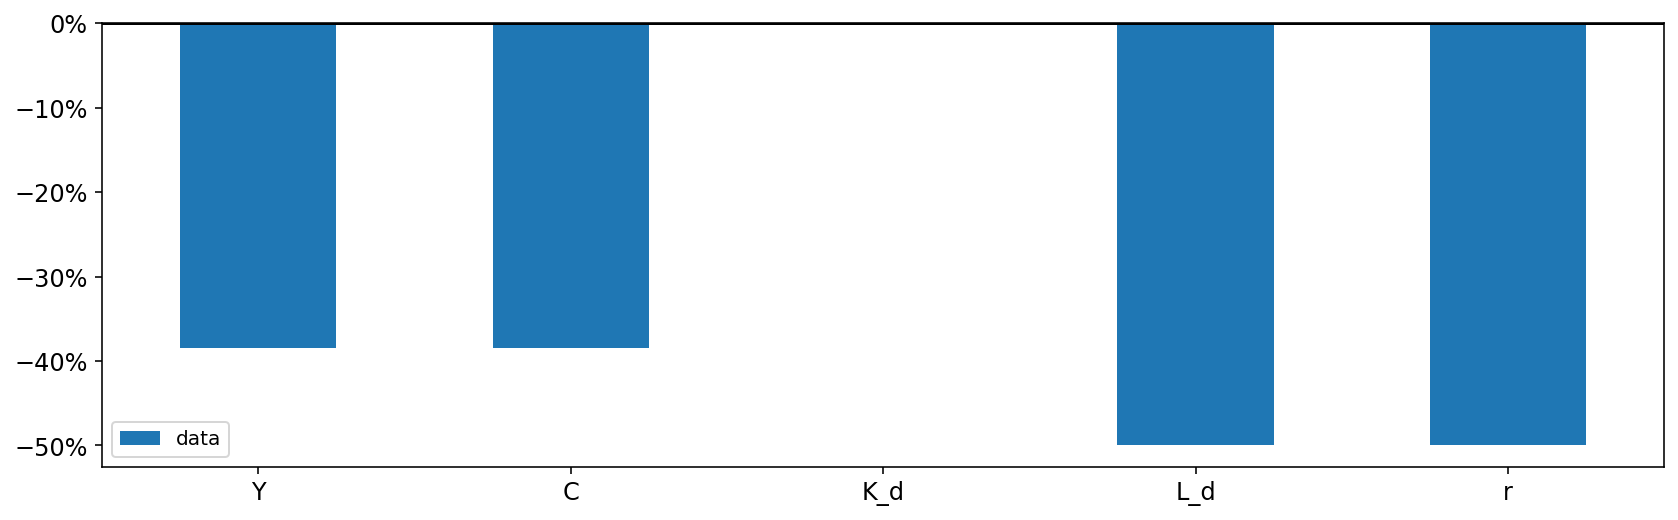

In [25]:
cgp.plot_bar(
    labor_cut,
    mod,
    var_names=["Y", "C", "K_d", "L_d", "r"],
    plot_together=True,
    figsize=(14, 4),
    legend=True,
    metric="pct_change",
);

Thanks for the Euler Approximation approach, we can also trace out the effect of each "step" in the labor supply reduction on all the other variables. We can see this with `plot_lines`.

In this case, we see that the reduction in all variables is essentially linear in the labor supply. This makes sense, since the driving effect is the shifting inward of the household budget constraint.

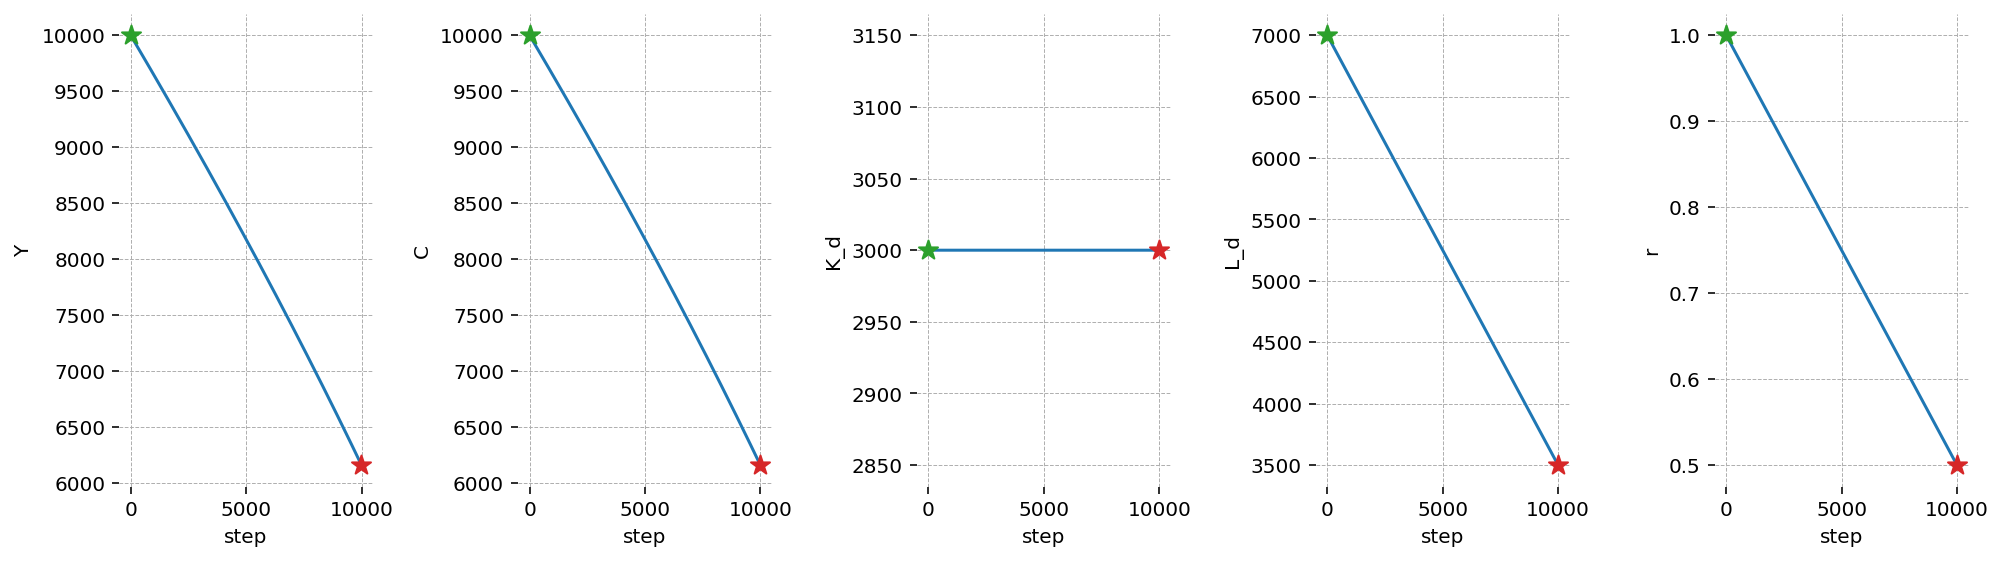

In [26]:
cgp.plot_lines(
    labor_cut, mod, var_names=["Y", "C", "K_d", "L_d", "r"], figsize=(14, 4)
);